In [13]:
import os
import csv
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
#config
config = {
    'data_set': '../../../data/filtered-dataset-no-header.csv',
    'model': {
        'log': False,
        'log_location':'../logs',
        'save_location': '../models',
        'layer_size': 120,
        'dropout_rate': 0.5,
        'learning_rate': 0.0005
    },
    'batch_size': 10000,
    'epochs': 1,
    'validation_set_size': 0.1,
    'lambda1': 0.5,
    'lambda2' : 0.01,
    'save_graphs': False,
    'graph_locations': '../graphs'
}


def select_device():
    #set up environment
    if torch.cuda.is_available():
        print("Using CUDA cores")
        return torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 

    else:
        print("Using CPU cores")
        return torch.device("cpu")
        

device = select_device()

Using CUDA cores


In [14]:
class Net(nn.Module):
    #constructor
    def __init__(self, num_units, dropout_rate):
        super(Net, self).__init__() #superclass constructor
        self.fc1 = nn.Linear(10,num_units)
        self.fc2 = nn.Linear(num_units,num_units)
        self.fc3 = nn.Linear(num_units,2)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.batchnorm = nn.BatchNorm1d(num_units)

    def forward(self, x):
        x = self.nonlin(self.fc1(x))
        x = self.batchnorm(x)
        x = self.nonlin(self.fc2(x))
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [15]:
def load_data_set(filename, validation_set_size, delimiter=','):
    dataset = []
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for row in reader:
            dataset.append(np.array([row]))
    print(f'The size of the entire dataset is {len(dataset)} points')
    val_size = int(len(dataset) * validation_set_size)
    return [dataset[:-val_size], dataset[-val_size:]]
    

def forward_pass(X,y,train = False):
    if train:
        optimizer.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i, 0) == torch.argmax(j,0) for i,j in zip(outputs,y)]

    acc = matches.count(True)/len(matches)
    cross_entropy_loss = loss_function(outputs,y)

    all_linear1_params = torch.cat([x.view(-1) for x in net.fc1.parameters()])
    all_linear2_params = torch.cat([x.view(-1) for x in net.fc2.parameters()])
    l1_regularization = lambda1 * torch.norm(all_linear1_params, 1)
    l2_regularization = lambda2 * torch.norm(all_linear2_params, 2)

    loss = cross_entropy_loss + l1_regularization + l2_regularization

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(test_X, test_y, size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = forward_pass(X.view(-1,10).to(device), y.to(device).view(-1,2))
    return val_acc, val_loss

def train(train_X, train_y, net,model_name, model_log_filename):
    log = {
        'times': [],
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
    }
    for epochs in range(config['epochs']):
        for i in tqdm(range(0, len(train_X), config['batch_size'])): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:100] ..for now just to dev
            batch_X = train_X[i:i+config['batch_size']].view(-1,10)
            batch_y = train_y[i:i+config['batch_size']].view(-1, 2)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            acc, loss = forward_pass(batch_X, batch_y, train=True)
        
            if i % config['batch_size'] == 0:
                val_acc, val_loss = test(test_X, test_y, size=config['batch_size'])
                log['times'].append(time.time())
                log['acc'].append(round(float(acc),2))
                log['loss'].append(round(float(loss), 4))
                log['val_acc'].append(round(float(val_acc),2))
                log['val_loss'].append(round(float(val_loss),4))
    return log



def create_acc_loss_graph(training_results, model_name, save_graphs):
    times = training_results['times']
    accuracies = training_results['acc']
    losses = training_results['loss']
    val_accs = training_results['val_acc']
    val_losses = training_results['val_loss']

    #accuracy graph
    fog = plt.figure()
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(times, accuracies, label="train_acc",color="red")
    ax1.axes.get_xaxis().set_ticks([])
    ax1.legend(loc=2)
    ax1.set_title("Training and Valdiation Accuracy")
   
    ax2.plot(times,val_accs, label="val_acc")
    ax2.legend(loc=2)
  

    if save_graphs:
        plt.savefig(f"{config['graph_locations']}/{model_name}-accuracies.png")
    plt.show()


    #loss graph
    fog = plt.figure()
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    
    ax1.plot(times, losses, label="loss",color="red")
    ax1.axes.get_xaxis().set_ticks([])
    ax1.legend(loc=2)
    ax1.set_title("Training and Validation Loss")
    
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    
    if save_graphs:
         plt.savefig(f"{config['graph_locations']}/{model_name}-losses.png")
    plt.show()

def create_features_and_labels(dataset):
    features = []
    labels = []
    for point in dataset:
        features.append([int(x) for x in point[0][:10]])
        blue_victory = int(point[0][10]) #1 if blue victory, 0 otherwise
        labels.append([blue_victory, 1 - blue_victory])
    
    return [torch.Tensor(features), torch.Tensor(labels)]


The size of the entire dataset is 820926 points
100%|██████████| 74/74 [02:54<00:00,  2.36s/it]


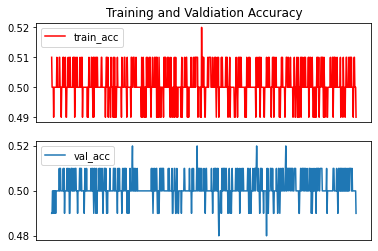

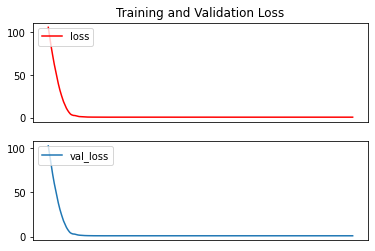

In [16]:
    
training_set, validation_set = load_data_set(config['data_set'], config['validation_set_size'])

train_X, train_y = create_features_and_labels(training_set)
test_X, test_y = create_features_and_labels(validation_set)

layer_size = config['model']['layer_size']
lambda1 = config['lambda1']
lambda2 = config['lambda2']

net = Net(layer_size,config['model']['dropout_rate']).to(device)

optimizer = optim.Adam(net.parameters(),lr = config['model']['learning_rate'])
model_name = f"model-layersize{layer_size}-{int(time.time())}"
log_location = config['model']['log_location']
model_log_file = f'{log_location}/{model_name}.log'
loss_function = nn.BCEWithLogitsLoss()

res = train(train_X, train_y, net,model_name, model_log_file)
#make the graphs
create_acc_loss_graph(res, model_name, config['save_graphs'])